# Practice Session 06: PageRank
<font size="+2" color="blue">Additional results: spam/nonspam visualization</font>

# 1. Read host names

In [1]:
import io
import gzip
import csv
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
INPUT_NODES_FILENAME = "webspam_uk2007-nodes.csv.gz"
INPUT_EDGES_FILENAME = "webspam_uk2007-edges.csv.gz"

In [3]:
with gzip.open(INPUT_NODES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    id2name = {} # Diccionario de ids a nombres web(url)
    id2label = {} # " " de ids a etiquetas
    name2id = {}  # " " de nombres web a ids
    for record in reader: # Se itera por cada fila del csv
        id = int(record["nodeid"]) # Se accede a los ids de las webs y se transforma de string a int
        name = record["hostname"] # Se accede al nombre de la web
        label = record["label"] # Se accede a la etiqueta de la web
        id2name[id] = name  # Cada id será la key del diccionario que los relacione con los nombres
        id2label[id] = label # " " con las etiquetas
        name2id[name] = id # Cada nombre web será la key que los relacione con los ids

In [4]:
# Leave as-is

print("%s: %s" % (id2name[873], id2label[873]))
print("%s: %s" % (id2name[105715], id2label[105715]))
print("Number of hosts: %s" % len(id2name))

bbc.co.uk: nonspam
www.top-mobile-phones.co.uk: spam
Number of hosts: 114529


In [5]:
spam = 0 # Contador spam
non_spam = 0 # Contador no spam
unlabeled = 0 # Contador sin clasificar 
for id in id2label: # Por cada id en id2label, es decir cada host itera para clasificar según el tipo de etiqueta que tenga con los siguientes ifs.
  if id2label[id] == "spam":
    spam += 1
  elif id2label[id] == "nonspam":
    non_spam += 1
  else:
    unlabeled += 1

print(("Spam hosts: %d\nNon-spam hosts: %d\nUnlabeled hosts: %d")%(spam,non_spam,unlabeled))

Spam hosts: 344
Non-spam hosts: 5709
Unlabeled hosts: 108476


In [6]:
g = nx.DiGraph()
spammywords = ['escort', 'xx', 'girl', 'credit', 'mortgage', 'finance', 'debt', 'loan']


with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader: 
        source = int(record["source"]) 
        destination = int(record["destination"])   
        for word in spammywords: # Itera por cada palabra de la lista de spammywords
          if word in id2name[source] or word in id2name[destination]: # Comprueba que o el source o el destination contengan una de las palabras seleccionadas
            if (id2label[source] == "spam" or id2label[source] == "nonspam") and (id2label[destination] == "spam" or id2label[destination] == "nonspam"): # Comprueba si tanto destino como origen contienen la etiqueta de spam o nonspam
              g.add_node(id2name[source])
              g.add_node(id2name[destination])
              g.add_edge(id2name[source], id2name[destination])

print(("The number of nodes is %d.")%(g.number_of_nodes()))

The number of nodes is 57.


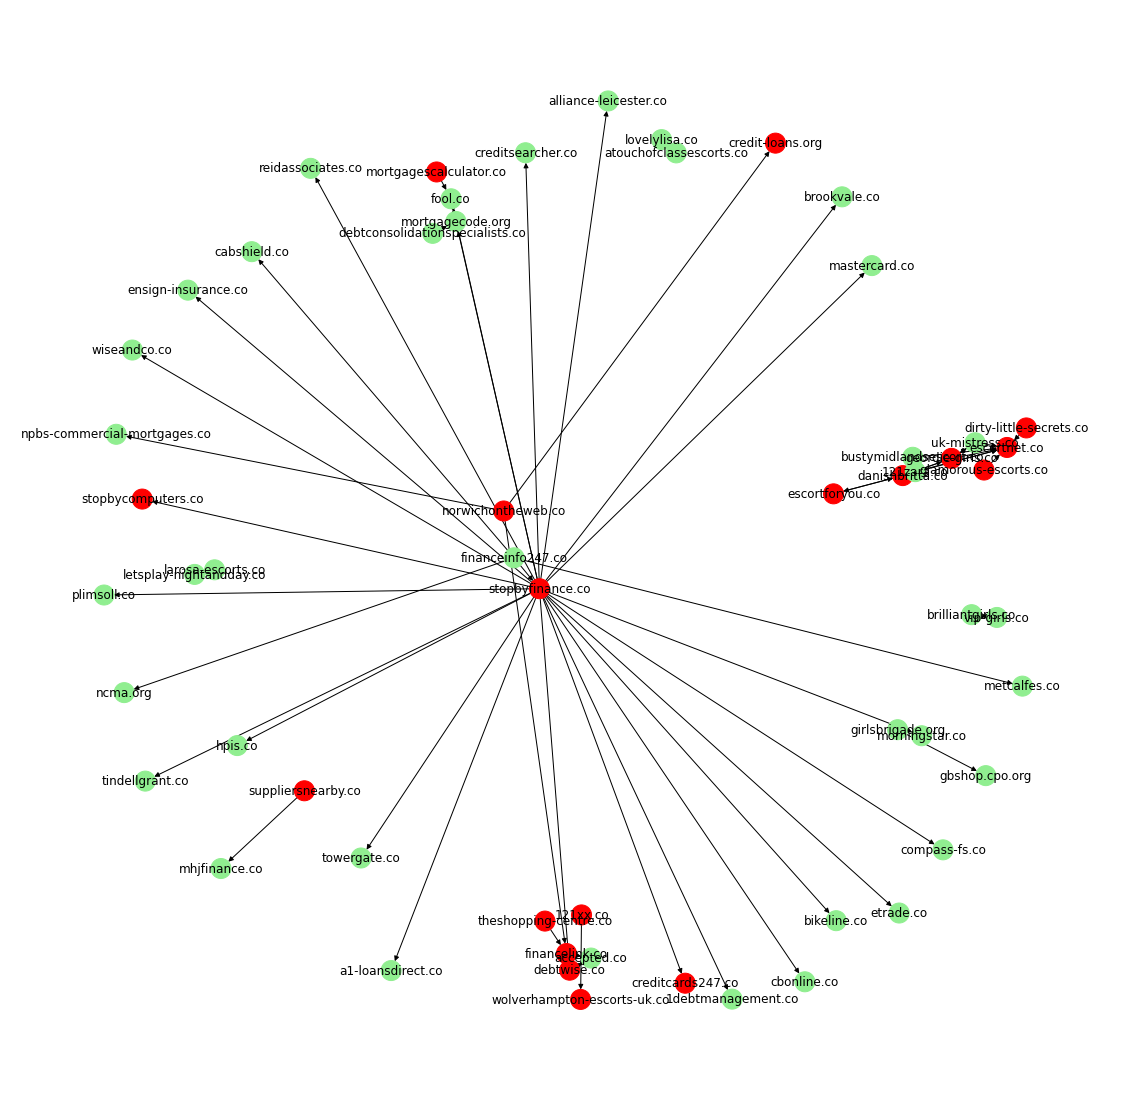

In [7]:
# Leave this code as-is, or modify slightly

colors = []
hostname_converted = {}

for hostname in g.nodes():
    # Assign colors to nodes according to spam/nonspam labels
    if id2label[name2id[hostname]] == 'spam':
        colors.append('red')
    elif id2label[name2id[hostname]] == 'nonspam':
        colors.append('lightgreen')
    else:
        colors.append('white')
    
    # Shorten the hostnames to generate labels    
    label = hostname.replace("www.", "").replace(".uk", "")
    hostname_converted[hostname] = label
    
# Notice that if you re-run this cell the layout will be different every time
plt.figure(figsize=(20, 20))
plt.axis('off')
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, node_size=400, node_color=colors, labels=hostname_converted)

Como se puede apreciar hay un nodo central cuyo grado es superior con creces al resto que sirve para enlazar los diferentes componentes conexos y singletons entre sí. A su vez se puede apreciar como las distintas temáticas de las webs redirigen a webs de una temática similar, por ejemplo las páginas relacionadas con finanzas dirigen a otras relacionadas con finanzas. Otra curiosidad es que bastantes páginas de spam dirigen a páginas clasificadas como no spam pero que contienen spammywords demostrando que a pesar de su etiqueta, pueden ser de spam.

# 2. Compute the degree of each node

In [8]:
# Leave this code as-is

id2degree = {}
N = len(id2name)
for nodeid in range(N):
    id2degree[nodeid] = 0

In [9]:
with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader: 
        source = int(record["source"]) 
        id2degree[source] += 1 # Por cada vez que se menciona un nodo como source, se añade 1 al outdegree.

In [10]:
# Leave this cell as-is

for nodeid in [890, 1469, 105715]:
    print("%s: degree %d" % (id2name[nodeid], id2degree[nodeid]))

bc1.org.uk: degree 16
candycaine.skinthesun.co.uk: degree 22
www.top-mobile-phones.co.uk: degree 0


# 3. Compute PageRank

In [11]:
# Leave this cell as-is

ITERATIONS = 20
ALPHA = 0.85

pagerank_aux = [0.0] * N
pagerank = [1.0/N] * N

In [12]:
for iteration in range(ITERATIONS): # Número de iteraciones
  print("Iteration %d of %d" % (iteration+1, ITERATIONS))
  with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader: 
      source = int(record["source"])
      destination = int(record["destination"])
      pagerank_aux[destination] += pagerank[source]/id2degree[source] # Cálculo del pagerank_aux que es la suma de todos los scores que reciben de sus indegrees.
  for i in range(N):  # Se itera por todos los nodos de la lista
    pagerank[i] = ALPHA * pagerank_aux[i] + (1-ALPHA)*(1.0/N)  # Se aplica la fórmula del pagerank
  pagerank_aux = [0.0]*N # Se reinicia el pagerank


Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20


# 4. Nodes with largest values of PageRank

In [13]:
hosts_by_score = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)

for i in range (20):
  print(("Nº%d: %s ,id: %d, with score %f (%s)\n")%(i+1, id2name[hosts_by_score[i][0]],hosts_by_score[i][0],hosts_by_score[i][1],id2label[hosts_by_score[i][0]]))

Nº1: www.opsi.gov.uk ,id: 81634, with score 0.001517 (unlabeled)

Nº2: www.adobe.co.uk ,id: 10990, with score 0.001418 (unlabeled)

Nº3: www.ico.gov.uk ,id: 60715, with score 0.000965 (unlabeled)

Nº4: www.dti.gov.uk ,id: 42757, with score 0.000896 (unlabeled)

Nº5: www.defra.gov.uk ,id: 39774, with score 0.000894 (unlabeled)

Nº6: news.bbc.co.uk ,id: 5169, with score 0.000780 (unlabeled)

Nº7: www.direct.gov.uk ,id: 40999, with score 0.000721 (unlabeled)

Nº8: www.dfes.gov.uk ,id: 40559, with score 0.000698 (unlabeled)

Nº9: www.fsa.gov.uk ,id: 51107, with score 0.000682 (unlabeled)

Nº10: www.nationalrail.co.uk ,id: 77619, with score 0.000658 (unlabeled)

Nº11: www.communities.gov.uk ,id: 34406, with score 0.000655 (unlabeled)

Nº12: www.bbc.co.uk ,id: 19504, with score 0.000648 (unlabeled)

Nº13: www.google.co.uk ,id: 54071, with score 0.000603 (unlabeled)

Nº14: www.dh.gov.uk ,id: 40612, with score 0.000591 (unlabeled)

Nº15: www.hmso.gov.uk ,id: 58631, with score 0.000582 (unlabel

Creo que tiene sentido que el que tenga un pagerank más alto, es decir, que las páginas más relevantes la señalen ya que habrán muchas páginas web importantes, con un indegree alto, es decir una puntuación de pagerank elevada que quieran mencionar o citar una actualización de una ley, un decreto, etc. Por otro lado el porcentaje de páginas web gubernamentales(.gov) con un pagerank elevado es enorme, de un 65% mientras que las comerciales, tales como adobe, nationaltrust, wanadoo, etc son un 35% y las educativas, si no consideramos educativas las gubernamentales y las de la bbc, es del 0%.

# 5. Run non-spam PageRank

In [14]:
id2nsdegree = {}
N = len(id2name)
for nodeid in range(N):
    id2nsdegree[nodeid] = 0

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader: 
        source = int(record["source"])
        destination = int(record["destination"])
        if id2label[source] != "spam" and id2label[destination] != "spam": # El cálculo es similar al anterior id2degree solo que esta vez se excluyen las páginas web que tengan la etiqueta spam.
          id2nsdegree[source] += 1

In [15]:
# Leave this cell as-is

for nodeid in [890, 1469, 105715]:
    print("%s: normal degree %d nospam degree %d" % (id2name[nodeid], id2degree[nodeid], id2nsdegree[nodeid]))

bc1.org.uk: normal degree 16 nospam degree 16
candycaine.skinthesun.co.uk: normal degree 22 nospam degree 20
www.top-mobile-phones.co.uk: normal degree 0 nospam degree 0


In [16]:
ITERATIONS = 20
ALPHA = 0.85

pagerank_aux = [0.0] * N
nspagerank = [1.0/N] * N


for iteration in range(ITERATIONS):
  print("Iteration %d of %d" % (iteration+1, ITERATIONS))
  with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
    for record in reader: 
      source = int(record["source"])
      destination = int(record["destination"])
      if id2label[source] != "spam" and id2label[destination] != "spam": # Se filtran aquellos enlaces de páginas web que tengan la etiqueta de spam, tanto la web de origen como la de destino.
        pagerank_aux[destination] += nspagerank[source]/id2nsdegree[source]
  for i in range(N):  
    nspagerank[i] = ALPHA * pagerank_aux[i] + (1-ALPHA)*(1.0/N) 
  pagerank_aux = [0.0] * N

Iteration 1 of 20
Iteration 2 of 20
Iteration 3 of 20
Iteration 4 of 20
Iteration 5 of 20
Iteration 6 of 20
Iteration 7 of 20
Iteration 8 of 20
Iteration 9 of 20
Iteration 10 of 20
Iteration 11 of 20
Iteration 12 of 20
Iteration 13 of 20
Iteration 14 of 20
Iteration 15 of 20
Iteration 16 of 20
Iteration 17 of 20
Iteration 18 of 20
Iteration 19 of 20
Iteration 20 of 20


In [17]:
nshosts_by_score = sorted(enumerate(nspagerank), key=lambda x: x[1], reverse=True)
for i in range (20):
  print(("N%d: %s,id: %d, with score %f (%s)\n")%(i+1, id2name[nshosts_by_score[i][0]],nshosts_by_score[i][0],nshosts_by_score[i][1],id2label[nshosts_by_score[i][0]]))

N1: www.opsi.gov.uk,id: 81634, with score 0.001516 (unlabeled)

N2: www.adobe.co.uk,id: 10990, with score 0.001418 (unlabeled)

N3: www.ico.gov.uk,id: 60715, with score 0.000964 (unlabeled)

N4: www.dti.gov.uk,id: 42757, with score 0.000895 (unlabeled)

N5: www.defra.gov.uk,id: 39774, with score 0.000893 (unlabeled)

N6: news.bbc.co.uk,id: 5169, with score 0.000780 (unlabeled)

N7: www.direct.gov.uk,id: 40999, with score 0.000720 (unlabeled)

N8: www.dfes.gov.uk,id: 40559, with score 0.000698 (unlabeled)

N9: www.fsa.gov.uk,id: 51107, with score 0.000680 (unlabeled)

N10: www.nationalrail.co.uk,id: 77619, with score 0.000657 (unlabeled)

N11: www.communities.gov.uk,id: 34406, with score 0.000655 (unlabeled)

N12: www.bbc.co.uk,id: 19504, with score 0.000648 (unlabeled)

N13: www.google.co.uk,id: 54071, with score 0.000602 (unlabeled)

N14: www.dh.gov.uk,id: 40612, with score 0.000591 (unlabeled)

N15: www.hmso.gov.uk,id: 58631, with score 0.000582 (unlabeled)

N16: www.hse.gov.uk,id: 5

# 6. Compute spam gain

In [18]:
spam_gain = [0.0]*N
for i in range(N):
  spam_gain[i] = pagerank[i]/nspagerank[i]

hosts_by_sg = sorted(enumerate(spam_gain), key=lambda x: x[1], reverse=True)
for i in range (50):
  print(("N%d: %s (%s) with spam gain of %.2f (PageRank: %.1E and Non-spam PageRank: %.1E)\n")%(i+1, id2name[hosts_by_sg[i][0]],id2label[hosts_by_sg[i][0]], round(hosts_by_sg[i][1],2), pagerank[i],nspagerank[i]))

N1: www.escortnet.co.uk (spam) with spam gain of 33.14 (PageRank: 1.3E-06 and Non-spam PageRank: 1.3E-06)

N2: www.missionfish.org.uk (spam) with spam gain of 29.06 (PageRank: 1.8E-06 and Non-spam PageRank: 1.8E-06)

N3: www.statistics.006.free-counter.co.uk (spam) with spam gain of 17.90 (PageRank: 1.3E-06 and Non-spam PageRank: 1.3E-06)

N4: www.uk-shoponline.co.uk (spam) with spam gain of 13.64 (PageRank: 1.7E-06 and Non-spam PageRank: 1.7E-06)

N5: www.shop.co.uk (spam) with spam gain of 10.80 (PageRank: 1.7E-06 and Non-spam PageRank: 1.7E-06)

N6: www.geordie-girls.co.uk (spam) with spam gain of 10.42 (PageRank: 2.3E-06 and Non-spam PageRank: 2.3E-06)

N7: www.into.demon.co.uk (spam) with spam gain of 10.35 (PageRank: 2.2E-06 and Non-spam PageRank: 2.2E-06)

N8: www.computerarts.co.uk (spam) with spam gain of 10.07 (PageRank: 1.7E-06 and Non-spam PageRank: 1.7E-06)

N9: www.aili.co.uk (unlabeled) with spam gain of 9.32 (PageRank: 2.3E-06 and Non-spam PageRank: 2.3E-06)

N10: conne


En la lisa se pueden ver tanto sitios legitimos donde sitios web de spam apuntan como sitios de spam, que son la gran mayoría, sin ir más lejos los primeros. Uno de los posibles motivos por los cuales la puntuación es la misma se debe a la acción de los nodos que no están conectas y que se añaden enlaces imaginarios con (1-ALPHA)/N ya que con las iteraciones, este valor a pesar de ser bajo en relación al peso de los enlaces reales (0.15 imaginarios y 0.85 reales) , va cogiendo peso por la repetición, es por el mismo motivo que tanto el pagerank como el nspagerank tienen top hosts similares.

In [43]:
OUTPUT_SPAM_EDGES = "web_spam_uk_edges.csv" 
OUTPUT_SPAM_NODES = "web_spam_uk_nodes.csv"
uk_tag = ".co.uk"

selected_hosts = sorted(enumerate(pagerank), key=lambda x: x[1], reverse=True)
min_pagerank = selected_hosts[30000][1] # Top 30000 hosts por pagerank, pero al filtrarse por co.uk y que no sean unlabeled, no habrán 30000 nodos, sino bastantes menos

with gzip.open(INPUT_EDGES_FILENAME, "rt", encoding="utf-8") as input_file:
  reader = csv.DictReader(input_file, delimiter=',', quotechar='"')
  with io.open(OUTPUT_SPAM_EDGES, "w") as fileout: # Crea un nuevo csv 
    edges = csv.writer(fileout, delimiter='\t', quotechar='"')
    edges.writerow(["Source", "Destination", "Weight"])
    for record in reader: 
      s = int(record["source"]) 
      d = int(record["destination"]) 
      source = id2name[s]
      destination = id2name[d]
      pagerank_score_s = pagerank[s]
      pagerank_score_d = pagerank[d]
      label_s = id2label[s]
      label_d = id2label[d]
      if label_s != "unlabeled" and label_d != "unlabeled":
        if pagerank_score_s >= min_pagerank  and pagerank_score_d >= min_pagerank: # Solo acepta sitios cuyo pagerank sea igual o superior al de muestra
          if uk_tag in source and uk_tag in destination: # Solo acepta aquellos edges que sean sitios webs de uk, tanto el origen como el destino
            weight = int(record["weight"])
            edges.writerow([s,d,weight])


with io.open(OUTPUT_SPAM_NODES, "w") as fileout: 
    edges = csv.writer(fileout, delimiter='\t', quotechar='"')
    edges.writerow(["Id", "Hostname", "Label", "Pagerank"])
    for key in id2name: 
      id = key  
      hostname = id2name[id]
      pagerank_score = pagerank[id]
      label = id2label[id]
      if label != "unlabeled":
        if pagerank_score >= min_pagerank: # Solo acepta sitios cuyo pagerank sea igual o superior al de muestra
          if uk_tag in hostname: # Solo acepta webs de UK
            label = id2label[id]
            edges.writerow([id,hostname,label,pagerank_score])
          


In [40]:
!["Web Spam de los top pagerank no unlabeled y de co.uk"](https://drive.google.com/file/d/1vj9--o93KepLcLjTTjDt1Tnn4zkEkSJ2/view?usp=sharing)

# Por si no se muestra el grafo, está en el zip de la práctica como web_spam_top_pagerank_co_uk.png.png


/bin/bash: -c: line 0: syntax error near unexpected token `https://drive.google.com/file/d/1vj9--o93KepLcLjTTjDt1Tnn4zkEkSJ2/view?usp=sharing'
/bin/bash: -c: line 0: `["Web Spam de los top pagerank no unlabeled y de co.uk"](https://drive.google.com/file/d/1vj9--o93KepLcLjTTjDt1Tnn4zkEkSJ2/view?usp=sharing)'


En el grafo se puede ver un componente central cuyo nodo de mayor grado es mysite.wanadoo-members.co.uk, que está en el top 20 de mayores pagerank, cumple con todas las condiciones, no es unlabeled, es perteneciente al dominio .co.uk y está entre los pageranks más altos. Otra curiosidad del grafo es que el grafo apenas posee nodos de spam, pero el nodo de mayor grado es una página de spam, uno de los núcleos del CC central: www.suppliersnearby.co.uk, que además curiosamente, la mayoria de sus enlaces es a páginas de no spam.



<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>